
<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Mission</h2>
</div>

- Le sujet porte sur le « Topic Modelling ». Il s’agit d’extraire les thèmes les plus récurrents depuis un ensemble de phrases. Les thèmes peuvent être des mots simples ou des mots composés de taille 2 ou 3 (n-grams).


<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#5d3a8e; font-size:40px'> Topic Modeling</h1>
</div>
- Topic modelling est une technique permettant d'extraire les sujets cachés de gros volumes de texte. Latent Dirichlet Allocation (LDA) est un algorithme populaire pour la modélisation de sujets. Le défi, cependant, est de savoir comment extraire des sujets de bonne qualité qui sont clairs, séparés et significatifs. Cela dépend fortement de la qualité du prétraitement du texte et de la stratégie de recherche du nombre optimal de sujets. Ce tutoriel tente de résoudre ces deux problèmes.


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Content</h2>
</div>



1. Loading Data
2. EDA
3. Data Cleaning 
4. Phase Modeling: Bi-grams and Tri-grams
- Method 1:
5. Data Transformation: Corpus and Dictionary
6. Base Model 
7. Hyper-parameter Tuning 
8. Final Model 
9. Visualize Results
- Method 2:
10. TF-IDF
11. GridSearch



In [2]:
!wget  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.
tar: Error opening archive: Failed to open 'faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2'
'cp' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\PC\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install pyLDAvis

You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
!pip install - U gensim

ERROR: Invalid requirement: '-'
You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


In [240]:
import re
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from collections import defaultdict
from pprint import pprint
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams

import string
from wordcloud import WordCloud
import gensim
import spacy
from spacy.tokenizer import Tokenizer


pd.set_option('display.max_columns', None)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Step 1: Loading Data</h2>
</div>

In [248]:
data= pd.read_csv("DataSet.txt",  names=['documents'])
data.head()

,documents
0,Innovation in Database Management: Computer Sc...
1,High performance prime field multiplication fo...
2,enchanted scissors: a scissor interface for su...
3,Detection of channel degradation attack by Int...
4,Pinning a Complex Network through the Betweenn...


In [242]:
data.shape

(2507, 1)


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Step 2: EDA 🛠</h2>
</div>

In [102]:
# pandas profiling : 
import pandas_profiling
profile = data.profile_report(
    title='Pandas Profiling Report')
profile.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### The common stopwords in corpus:

In [127]:
def create_corpus():
    corpus=[]
    for x in data["documents"].str.split():
        for i in x:
            corpus.append(i)
    return corpus
data_corpus= create_corpus()
print(data_corpus[10:15])

['prime', 'field', 'multiplication', 'for', 'GPU.']


In [128]:
stop=set(stopwords.words('english'))
dic= defaultdict(int)
for word in data_corpus:
    if word in stop:
        dic[word]+=1
top = sorted(dic.items(), key= lambda x:x[1], reverse=True)[:20]

# Display the stowords
np.array(stop)

array({'because', 'theirs', 'couldn', "wouldn't", "mightn't", "hadn't", 'didn', 'it', "isn't", 'now', 'hasn', 'yourself', 'more', 'when', 'have', 'few', "you'd", 'after', "don't", 'yourselves', 'then', 'than', 'll', 'are', 'as', 'below', 'up', 'same', 'be', "she's", 'themselves', 'this', 'there', 'some', 'needn', 'off', 'will', 'd', 'am', 'being', 'their', "haven't", 'his', 'further', "couldn't", 'most', 'doing', 'was', 'wasn', 'out', 'weren', 'against', 've', 'each', 'such', 'to', "wasn't", 'with', 'ourselves', 'him', 'other', 'hadn', 'does', "you're", 'from', 'which', 'down', 'having', 'no', 'how', 'been', 'that', 'above', 'too', 'an', 'herself', 'while', 's', 'ain', 'we', 'once', "you've", 'isn', 'all', 'or', 'during', 'so', 'her', 'ma', "you'll", 'them', 'is', 'until', "doesn't", 'has', 'about', 'myself', 'yours', 'ours', 'shan', 'hers', 'can', "weren't", 'were', 'here', 'both', 'very', 'y', 'me', 'not', 'but', 'aren', 'own', 'under', 'himself', 'and', 'they', 'i', 'don', 'had', 'o

<BarContainer object of 20 artists>

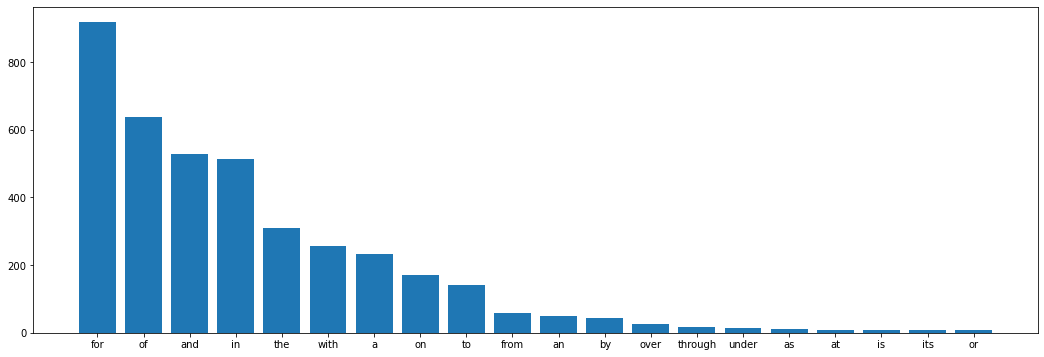

In [129]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

### Analysing punctuations

<BarContainer object of 4 artists>

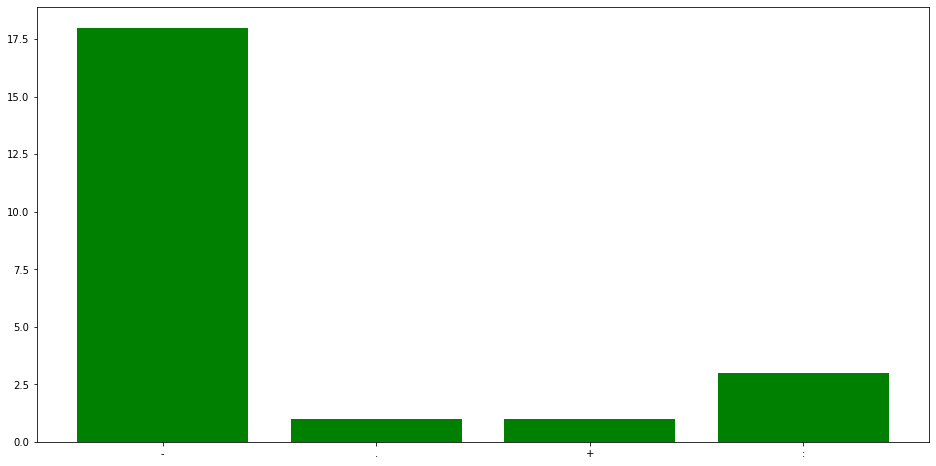

In [106]:
plt.figure(figsize=(16, 8))
data_corpus= create_corpus()

dic= defaultdict(int)
special= string.punctuation
for i in (data_corpus):
    if i in special:
        dic[i]+=1

        
x, y= zip(*dic.items())   
plt.bar(x, y, color='green')


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Step 3: Data Cleaning</h2>
</div>

### Remove punctuation / lower casing

In [253]:
def clean_text(text):
    # Make text lowercase
    text = str(text).lower()
    # remove text in square brackets,
    text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove punctuation rajouter les if pour ne pas supprimer les .net et c++!!!!!!!!!!!!
    #text = re.sub('<*?>', '', text )
    # remove words containing numbers.
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def remove_contract_form(text):
    document = nltk.word_tokenize(text) 
    words = []
    for token in document:
        text = token
        text = re.sub(r"\'m", "am", text)
        text = re.sub(r"\'re", "are", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"n't", "not", text)
        text = re.sub(r"\'ve", "have", text)
        text = re.sub(r"\'d", "would", text)
        text = re.sub(r"\'ll", "will", text)
        words.append(text)
    return ' '.join(words)

def delete_multiple_space(text):
    return ' '.join(text.split())


# Delete string of length = 1 
def low_length(text):
    document = nlp(text)
    words = []
    for token in document:
        if len(token.text) > 1:
            words.append(token.text)
    
    return ' '.join(words)

In [256]:
# Remove punctuation and Convert to lowercase 
data['documents_processed']= data['documents'].apply(clean_text)
# Remove Contract Forms 
data['documents_processed']= data['documents_processed'].apply(remove_contract_form)
# Remove Multiple Space
data['documents_processed']= data['documents_processed'].apply(delete_multiple_space)
# Remove a words with lenght<1
data['documents_processed']= data['documents_processed'].apply(low_length)

data.head()

,documents,documents_processed
0,Innovation in Database Management: Computer Sc...,innovation in database management computer sci...
1,High performance prime field multiplication fo...,high performance prime field multiplication fo...
2,enchanted scissors: a scissor interface for su...,enchanted scissors scissor interface for suppo...
3,Detection of channel degradation attack by Int...,detection of channel degradation attack by int...
4,Pinning a Complex Network through the Betweenn...,pinning complex network through the betweennes...


### Tokenize words and further clean-up documents

In [257]:
import gensim 
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_lst= data.documents_processed.values.tolist()
data_words= list(sent_to_words(data_lst))

print(data_words[:1][0][:30])

['innovation', 'in', 'database', 'management', 'computer', 'science', 'vs', 'engineering']



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Step 4: Phase Modeling: Bi-grams and Tri-grams</h2>
</div>

In [258]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove Stopwords, Make Bigrams and Lemmatize:

In [259]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [260]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [262]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [264]:
print(data_lemmatized[:10])

[['innovation', 'database', 'management', 'computer', 'science', 'engineering'], ['high', 'performance', 'prime', 'field', 'multiplication', 'gpu'], ['enchant', 'scissor', 'scissor', 'interface', 'support', 'cut', 'interactive', 'fabrication'], ['detection', 'channel', 'degradation', 'attack', 'intermediary', 'node', 'linear', 'network'], ['pin', 'complex', 'network', 'betweenness', 'centrality', 'strategy'], ['analysis', 'design', 'memoryless', 'interconnect', 'encode', 'scheme'], ['dynamic', 'bluescreen'], ['quantitative', 'assure', 'forwarding', 'service'], ['automatic', 'sanitization', 'social', 'network', 'datum', 'prevent', 'inference', 'attack'], ['uwb', 'radar', 'sub', 'mm', 'ranging', 'capability', 'human', 'body', 'monitoring', 'system']]


In [265]:
data['data_cleaned']= data_lemmatized
data['data_cleaned']=[','.join(map(str, l)) for l in data['data_cleaned']]
data.head()

,documents,documents_processed,data_cleaned
0,Innovation in Database Management: Computer Sc...,innovation in database management computer sci...,"innovation,database,management,computer,scienc..."
1,High performance prime field multiplication fo...,high performance prime field multiplication fo...,"high,performance,prime,field,multiplication,gpu"
2,enchanted scissors: a scissor interface for su...,enchanted scissors scissor interface for suppo...,"enchant,scissor,scissor,interface,support,cut,..."
3,Detection of channel degradation attack by Int...,detection of channel degradation attack by int...,"detection,channel,degradation,attack,intermedi..."
4,Pinning a Complex Network through the Betweenn...,pinning complex network through the betweennes...,"pin,complex,network,betweenness,centrality,str..."


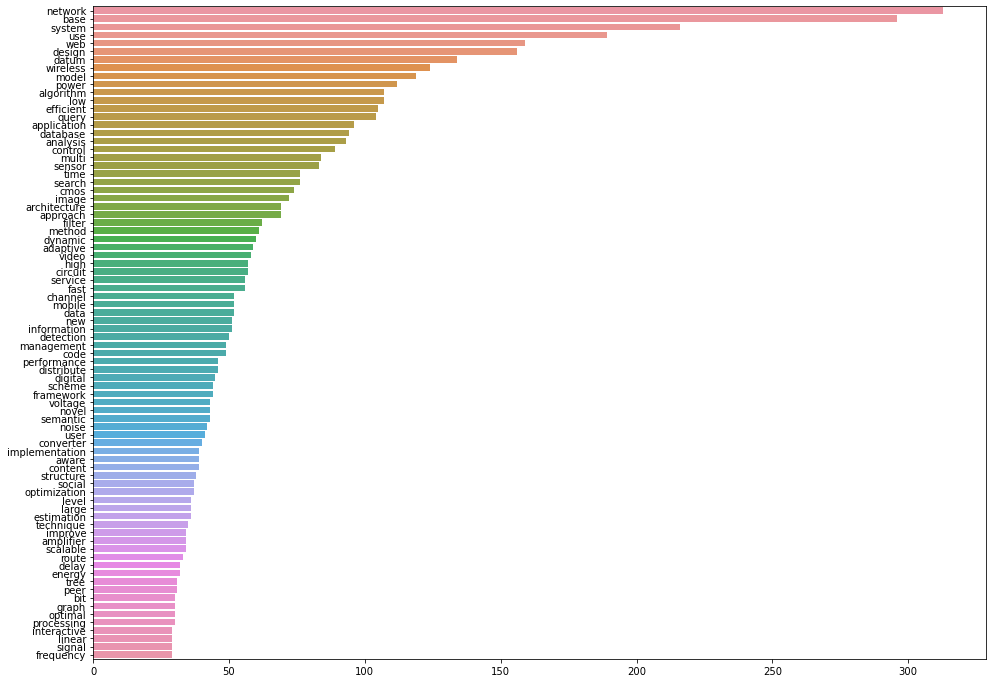

In [266]:
plt.figure(figsize=(16, 12))
#convert the list of list into a flat list 
dt_corpus= [ item for elem in data_lemmatized for item in elem]

counter= Counter(dt_corpus)
most= counter.most_common()
x=[]
y=[]
for word, count in most[:80]:
    if(word not in stop and word not in special):
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.show()

### WordCloud of the documents:

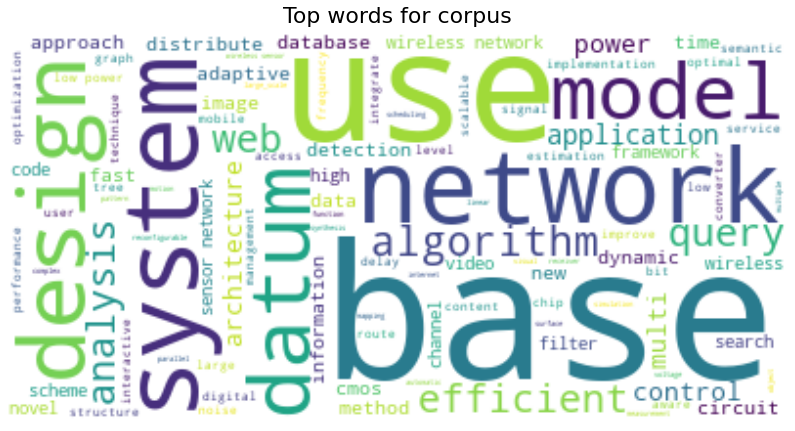

In [267]:
wc = WordCloud(
    background_color='white', 
    max_words=100, 
)
wc.generate(' '.join(text for text in data['data_cleaned']))
plt.figure(figsize=(14,8))
plt.title('Top words for corpus', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Step 5: Data transformation: Corpus and Dictionary:</h2>
</div>

In [268]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Step 6: Base Model</h2>
</div>

In [269]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=4, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [271]:
from pprint import pprint

# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"base" + 0.014*"low" + 0.012*"efficient" + 0.011*"power" + '
  '0.010*"network" + 0.009*"system" + 0.007*"control" + 0.007*"application" + '
  '0.006*"design" + 0.006*"scalable"'),
 (1,
  '0.015*"base" + 0.013*"system" + 0.012*"design" + 0.012*"use" + '
  '0.010*"circuit" + 0.009*"power" + 0.008*"time" + 0.008*"analysis" + '
  '0.007*"image" + 0.007*"cmos"'),
 (2,
  '0.023*"network" + 0.013*"query" + 0.013*"datum" + 0.011*"wireless" + '
  '0.010*"web" + 0.010*"base" + 0.008*"use" + 0.008*"video" + 0.008*"database" '
  '+ 0.007*"multi"'),
 (3,
  '0.023*"web" + 0.019*"network" + 0.011*"data" + 0.011*"use" + 0.010*"system" '
  '+ 0.009*"mobile" + 0.009*"datum" + 0.009*"user" + 0.008*"content" + '
  '0.008*"search"')]


In [272]:
no_top_words = 10
num_topics = 6
def display_topics(model, no_top_words, num_topics):
    for idx, topic in model.show_topics(formatted=False, num_topics=num_topics, num_words= no_top_words):
        print("--------------------------------------------")
        print("Topic %d:" % (idx))
        print(" ".join([w[0] for w in topic]))
        print("--------------------------------------------")
        
display_topics(lda_model, no_top_words, num_topics) 

--------------------------------------------
Topic 0:
base low efficient power network system control application design scalable
--------------------------------------------
--------------------------------------------
Topic 1:
base system design use circuit power time analysis image cmos
--------------------------------------------
--------------------------------------------
Topic 2:
network query datum wireless web base use video database multi
--------------------------------------------
--------------------------------------------
Topic 3:
web network data use system mobile datum user content search
--------------------------------------------


### Compute Model Perplexity and Coherence Score

In [273]:
# compute Perplexity - lower is the better
perplexity= lda_model.log_perplexity(corpus)
print('\nPerplexity: ', perplexity)


Perplexity:  -7.865312547534185


In [275]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.303137323355355


In [276]:
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models as pgm

lda_vis= pgm.prepare(lda_model, corpus, id2word)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.052156  0.143665       1        1  27.329552
1      0.136585  0.055726       2        1  25.148840
0      0.094462 -0.130921       3        1  24.556985
3     -0.178891 -0.068471       4        1  22.964623, topic_info=          Term        Freq       Total Category  logprob  loglift
291        web  156.000000  156.000000  Default  30.0000  30.0000
178        low   91.000000   91.000000  Default  29.0000  29.0000
256      query   85.000000   85.000000  Default  28.0000  28.0000
25     network  234.000000  234.000000  Default  27.0000  27.0000
166    circuit   44.000000   44.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
286  framework   16.337781   34.949756   Topic4  -5.5046   0.7108
67        base   25.280478  239.225920   Topic4  -5.0680  -0.7762
204   adaptive   15.594210   47.659035   Topic4  -5.5512   0.3540
33      design   16.860384  118.648695   Topic4  -5.4731  -0.4800
131   wireless   16.606796  114.190529   Topic4  -5.4882  -0.4568

[266 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
549       1  0.940382         abstract
3099      1  0.936675           ad_hoc
861       2  0.985349  ad_hoc_networks
204       1  0.461612         adaptive
204       2  0.146877         adaptive
...     ...       ...              ...
131       2  0.192660         wireless
131       3  0.210175         wireless
131       4  0.148874         wireless
464       1  0.837586              xml
464       3  0.167517              xml

[340 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Step 7: Hyperparameter tuning</h2>
</div>

In [277]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [278]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 8
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
               corpus]   #Return a corpus that is the “head” of input iterable corpus.

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 360/360 [2:09:06<00:00, 21.52s/it]


In [279]:
Results= pd.read_csv('lda_tuning_results.csv')
Results.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.278577
1,75% Corpus,2,0.01,0.31,0.285571
2,75% Corpus,2,0.01,0.61,0.228247
3,75% Corpus,2,0.01,0.9099999999999999,0.228472
4,75% Corpus,2,0.01,symmetric,0.250753


In [281]:
def best_hyperparam(data):
    iters= data.where(data["Coherence"]==data["Coherence"].max())
    iters.dropna(how="all", inplace=True)
    print("le meilleurs score est: ",iters)
    if iters.shape[0]>0:
        iters= iters.iloc[0,:]
    #print(iters)    
        
    return iters    
best_hyperparam= best_hyperparam(Results)

le meilleurs score est:      Validation_Set  Topics       Alpha                Beta  Coherence
118     75% Corpus     5.0  asymmetric  0.9099999999999999   0.578325




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Step 8: Final Model</h2>
</div>

In [282]:
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [283]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"network" + 0.009*"base" + 0.008*"efficient" + 0.008*"web" + '
  '0.007*"datum" + 0.007*"system" + 0.006*"wireless" + 0.006*"approach" + '
  '0.005*"multi" + 0.005*"information"'),
 (1,
  '0.013*"design" + 0.011*"base" + 0.009*"database" + 0.008*"system" + '
  '0.007*"use" + 0.005*"circuit" + 0.005*"cmos" + 0.005*"image" + '
  '0.005*"power" + 0.004*"detection"'),
 (2,
  '0.012*"base" + 0.011*"use" + 0.009*"query" + 0.008*"search" + 0.008*"low" + '
  '0.007*"power" + 0.007*"system" + 0.006*"application" + 0.006*"algorithm" + '
  '0.005*"adaptive"'),
 (3,
  '0.020*"web" + 0.009*"datum" + 0.008*"semantic" + 0.007*"network" + '
  '0.007*"user" + 0.006*"service" + 0.005*"social" + 0.004*"information" + '
  '0.004*"model" + 0.004*"generate"'),
 (4,
  '0.024*"network" + 0.015*"wireless" + 0.009*"sensor" + 0.006*"base" + '
  '0.006*"system" + 0.006*"control" + 0.006*"mobile" + 0.005*"route" + '
  '0.005*"delay" + 0.004*"multi"')]


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Step 9: Visualize results</h2>
</div>

In [284]:
!pip install pyLDAvis

You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


In [285]:
import pyLDAvis.sklearn
import gensim

pyLDAvis.enable_notebook()

import pyLDAvis.gensim_models as pgm

lda_vis= pgm.prepare(lda_model, corpus, id2word)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.082916  0.000106       1        1  30.517092
1      0.027226  0.027349       2        1  21.837767
0     -0.023723 -0.002698       3        1  18.646429
4     -0.025620 -0.066024       4        1  17.124654
3     -0.060799  0.041267       5        1  11.874058, topic_info=           Term        Freq       Total Category  logprob  loglift
291         web   84.000000   84.000000  Default  30.0000  30.0000
25      network  138.000000  138.000000  Default  29.0000  29.0000
131    wireless   66.000000   66.000000  Default  28.0000  28.0000
33       design   77.000000   77.000000  Default  27.0000  27.0000
289      search   49.000000   49.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
4    management    4.976734   23.217297   Topic5  -6.0337   0.5907
337    approach    5.334713   38.224342   Topic5  -5.9642   0.1616
183      mobile    3.794691   32.416180   Topic5  -6.3049  -0.0142
58       system    4.087749  109.734516   Topic5  -6.2305  -1.1593
67         base    4.140051  155.384197   Topic5  -6.2177  -1.4944

[313 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
326       1  0.133781    access
326       2  0.133781    access
326       3  0.200672    access
326       4  0.200672    access
326       5  0.267563    access
...     ...       ...       ...
131       2  0.015025  wireless
131       3  0.300493  wireless
131       4  0.661084  wireless
1976      1  0.191587    xquery
1976      3  0.574760    xquery

[727 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])

In [287]:
pyLDAvis.save_html(lda_vis, 'lda.html')

# Method N2: Using TF-IDF:


In [199]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer , TfidfTransformer

X= data_lemmatized
X=[' '.join(map(str, l)) for l in X]


- max_df=0.7 means we discard any words that appear in >70% of topics. In this dataset I don’t think there are any words that are that common but it is good practice. We will also filter words using min_df=1, so words that appear in less than 1 topics will be discarded. We discard high appearing words since they are too common to be meaningful in topics. We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

In [201]:
from sklearn.feature_extraction.text import TfidfTransformer

vectorizerIdf = TfidfVectorizer(analyzer='word',
                                    min_df=0.01,
                                    max_df=0.7,
                                    strip_accents=None,
                                    encoding='utf-8',
                                    preprocessor=None,
                                    token_pattern=r'(?u)\b\w+\b',
                                    # token_pattern=r"(?u)\S\S+",
                                    max_features=2000) 

X_IDF= vectorizerIdf.fit_transform(X)
X_IDF

<2507x96 sparse matrix of type '<class 'numpy.float64'>'
	with 5820 stored elements in Compressed Sparse Row format>

In [203]:
tf_feature_names = vectorizerIdf.get_feature_names()

In [204]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [205]:
# Define Search Param
search_params = {'n_components': [4, 5, 6, 7, 8], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X_IDF)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [4, 5, 6, 7, 8]})

In [206]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_IDF))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
Best Log Likelihood Score:  -3746.56578895625
Model Perplexity:  133.83869562358385


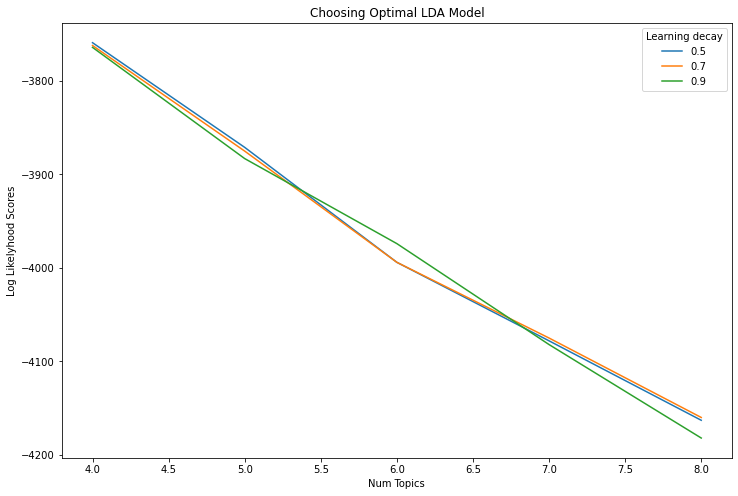

In [191]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [4, 5, 6, 7, 8]

log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]


# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [192]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(X_IDF)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(x))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.100000,0.100000,0.680000,0.110000,2
Doc1,0.390000,0.100000,0.400000,0.100000,2
Doc2,0.130000,0.130000,0.620000,0.130000,2
Doc3,0.090000,0.440000,0.350000,0.130000,1
Doc4,0.110000,0.110000,0.620000,0.170000,2
Doc5,0.090000,0.090000,0.470000,0.340000,2
Doc6,0.620000,0.130000,0.130000,0.130000,0
Doc7,0.620000,0.130000,0.130000,0.130000,0
Doc8,0.090000,0.090000,0.700000,0.110000,2
Doc9,0.620000,0.130000,0.130000,0.130000,0


In [194]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,781
1,3,616
2,2,589
3,1,521


In [195]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizerIdf.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,access,adaptive,algorithm,amplifier,analysis,application,approach,architecture,aware,base,bit,channel,chip,circuit,cmos,code,complex,content,control,converter,data,database,datum,delay,design,detection,device,digital,distribute,dynamic,efficient,energy,environment,estimation,fast,filter,framework,frequency,graph,high,image,implementation,improve,information,integrate,interactive,internet,large,large_scale,level,linear,low,management,measurement,method,mobile,mode,model,modulator,motion,multi,network,new,noise,novel,optimal,optimization,packet,performance,power,processing,query,rate,route,scalable,scheduling,scheme,search,semantic,sensor,service,signal,simulation,social,structure,system,technique,time,tree,use,user,video,voltage,web,wireless,xml
Topic0,0.258649,4.516607,12.177764,0.257673,0.256574,11.981405,0.253789,0.255786,0.256759,0.349313,5.879766,8.154369,16.931929,9.482181,12.345869,0.255894,0.251567,0.252687,1.223931,23.043442,0.253088,0.253739,0.255803,0.256083,21.687086,0.254820,17.174933,0.257148,0.258532,39.138091,0.513459,0.252941,0.255575,0.253454,34.208966,0.255753,0.254770,10.028757,3.143377,31.012317,0.254397,0.253764,0.252808,0.253960,0.255484,0.252083,0.255221,23.055712,18.275680,22.639451,0.252788,40.329393,0.258370,0.251276,0.253529,0.256549,0.257846,0.255025,0.252360,0.532518,46.824462,12.730419,0.254107,0.256359,5.113497,0.254092,22.470541,17.787437,0.260869,52.536533,0.253005,0.254885,0.256017,0.253248,23.020772,16.001352,3.086146,48.738082,0.253282,4.390041,36.904120,0.254274,0.255959,0.252078,0.253800,76.519004,0.257973,0.254183,21.953922,0.265950,0.255768,0.255819,0.260201,23.073263,12.288315,0.254668
Topic1,8.688112,9.171040,18.344695,22.841980,0.439991,12.904899,0.256858,0.255792,0.255611,125.070058,5.675981,21.158212,0.252254,25.914393,0.258710,8.465250,0.252919,26.143794,9.337847,0.671121,0.253239,0.253174,0.456601,5.887325,7.868471,31.486593,0.256264,25.033995,29.332115,0.254250,6.228313,0.252168,0.254945,21.153182,0.583478,0.257029,28.913977,7.722036,0.257125,0.253930,0.256881,25.294841,0.255997,0.254503,0.257593,0.253097,18.153694,0.253169,0.253716,0.255725,0.255327,0.254578,0.256323,19.656848,36.229200,0.252507,0.255164,0.257541,19.258668,16.103400,0.255043,0.261679,29.803475,0.262749,0.258531,0.255585,0.258351,0.252753,0.255724,0.255781,0.255691,0.253143,16.258497,0.252275,0.253410,0.253126,0.332866,0.254989,30.006722,0.254771,0.253438,0.262601,17.993587,0.256505,0.256602,0.419655,21.689105,41.421535,0.254236,26.461811,0.254613,16.129746,0.252661,5.737682,0.254076,19.839508
Topic2,0.635896,10.277403,33.365243,0.250887,56.120782,8.766170,0.266224,0.252404,0.253587,1.885302,7.039489,0.253932,0.250373,0.251708,0.253712,21.039673,19.231102,0.252584,0.253909,0.253733,0.255401,62.246979,79.179001,2.590748,51.580751,0.253839,0.255416,0.254999,0.256163,0.252689,0.260462,0.253292,17.299453,0.252872,0.253381,37.704317,0.255122,0.254305,18.260283,0.254911,44.614835,0.254848,22.841844,32.892423,0.254735,22.364446,0.253261,0.256148,0.253984,0.253111,19.100747,0.253927,12.086491,0.252210,0.254630,0.252880,0.252789,0.258036,0.251298,0.253539,0.253191,19.636713,0.252431,0.253816,0.254675,20.201993,0.255800,0.253453,27.584732,0.252875,19.116268,65.438804,0.251477,0.252963,0.254088,0.251574,0.257293,0.254775,0.256847,0.260683,0.251080,13.825018,0.253555,25.651461,23.520450,34.501392,0.252689,0.255237,0.253997,74.552442,0.254368,0.261281,0.253009,0.258601,0.254216,0.259323
Topic3,7.882423,9.788352,0.258435,0.255840,0.254335,19.646068,44.093235,44.738167,24.969116,6.969242,0.254673,0.259614,0.252763,0.257252,30.717451,0.260535,0.252499,0.259654,34.082228,0.255760,32.715983,0.253165,0.253937,12.828388,3.581532,0.252393,0.253860,0.254406,0.252910,0.254200,53.587003,20.989482,0.256272,0.254269,0.254101,0.255394,0.252598,0.256016,0.252995,0.254016,0.256067,0.253903,0.253625,0.255674,16.298914,0.252757,0.253156,0.255701,0.254112,0.251689,0.257919,10.754321,17.516061,0.253011,0.254570,32.928931,16.126170,69.887406,0.2